## Identifying poisonous mushrooms with machine learning

Can mushroom characteristics determine whether they're poisonous or not?

Mushroom foraging isn't without its dangers, which is why it's important to be able to identify differences between edible and poisonous mushrooms. Using machine learning, these models attempt to determine whether a mushroom is poisonous or not based on their characteristics.

Models used:
* Logistic Regression
* Naive Bayes
* XGBoost

The dataset is from The Audubon Society Field Guide to North American Mushrooms (1981) and found on [Kaggle](https://www.kaggle.com/datasets/uciml/mushroom-classification/data). It contains hypothetical samples of 23 species of gilled mushrooms.

In [2]:
## Initialising libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import base
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

## The data

In [3]:
## Loading the dataset
df = pd.read_csv('mushrooms.csv')

## Checking the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [4]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
## Checking the targets and potential skew in dataset
poison_mushroom_count = pd.DataFrame(df['class'].value_counts()).reset_index()
poison_mushroom_count['class'] = poison_mushroom_count['class'].str.replace('e', 'edible')
poison_mushroom_count['class'] = poison_mushroom_count['class'].str.replace('p', 'poisonous')
poison_mushroom_count

,class,count
0,edible,4208
1,poisonous,3916


In [6]:
## Plotting target data skew
colors = ['lightgreen', 'red']
fig = go.Figure(data=[go.Pie(labels=poison_mushroom_count['class'], 
                             values=poison_mushroom_count['count'],
                             direction='clockwise', marker=dict(colors=colors))])
fig.update_layout(title='Edible vs. poisonous mushrooms', legend_title='Class')
fig.show()

The target data is pretty balanced.

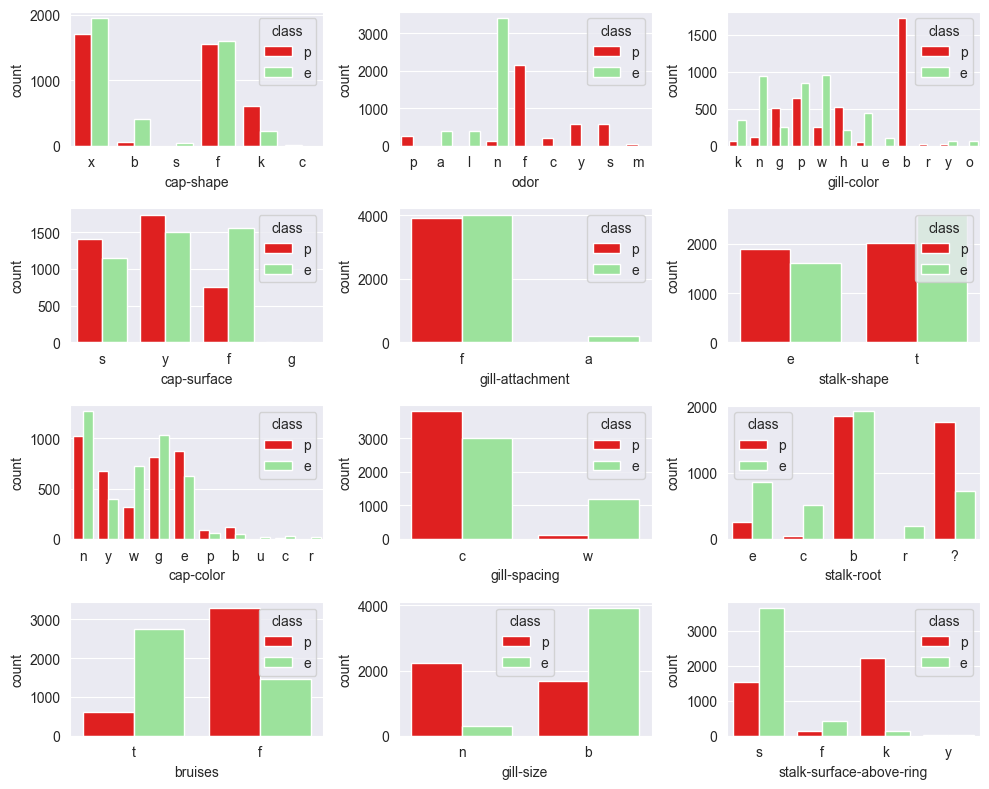

In [7]:
## Plotting the data by class
sns.set_style('darkgrid')

col_list = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring']
fig, axes = plt.subplots(4, 3, figsize=(10,8))
for i, feature in enumerate(col_list):
    sns.countplot(data=df, x=feature, hue='class', palette=['red', 'lightgreen'], ax=axes[i%4, i//4])

fig.tight_layout()

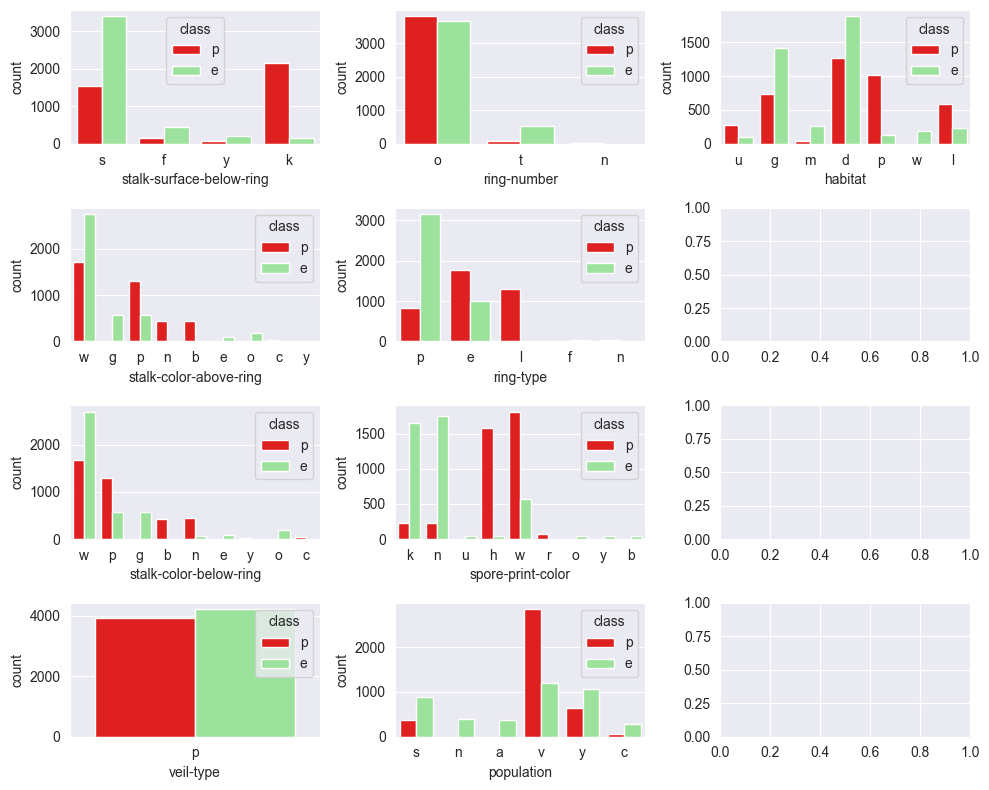

In [8]:
sns.set_style('darkgrid')
colors = sns.color_palette('hls', 8)

col_list = ['stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
fig, axes = plt.subplots(4, 3, figsize=(10,8))
for i, feature in enumerate(col_list):
    sns.countplot(data=df, x=feature, hue='class', palette=['red', 'lightgreen'], ax=axes[i%4, i//4])

fig.tight_layout()

Several features have an imbalanced distribution on the target data which may be detrimental to the models.

## Data cleaning

<Axes: >

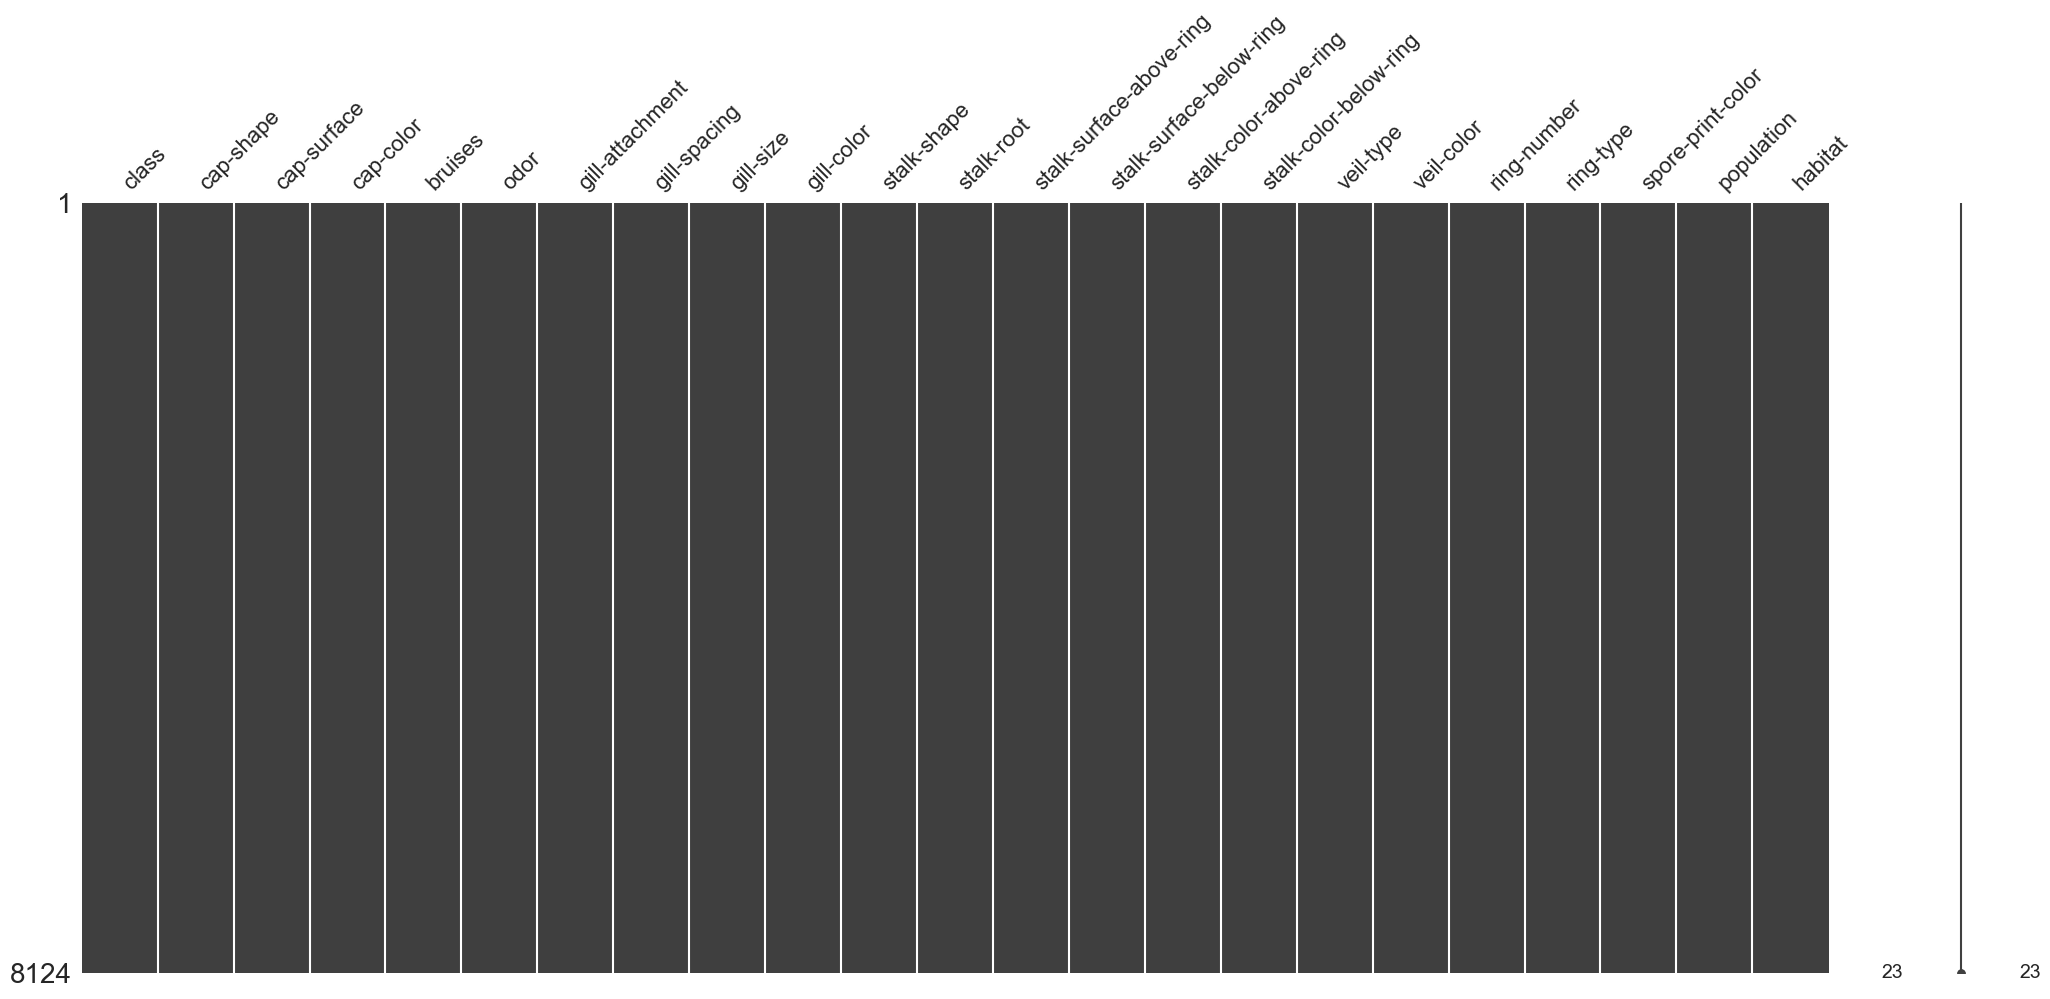

In [9]:
## Visualising amount of nulls
msno.matrix(df)

There appears to be no obvious nulls in the dataset.

In [10]:
## Checking variables for unique values
print(df['stalk-root'].unique())
print(df['veil-type'].unique())

['e' 'c' 'b' 'r' '?']
['p']


In [11]:
## Dropping the stalk-root and veil-type columns due to missing data and only one value
df = df.drop(columns = ['stalk-root', 'veil-type'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

All of the variables in the dataset are categorical and contain object datatypes. These need to be transformed to numeric values in order to be read by our models.

In [12]:
## Label encoding the class column
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,x,s,n,t,p,f,c,n,k,...,s,s,w,w,w,o,p,k,s,u
1,0,x,s,y,t,a,f,c,b,k,...,s,s,w,w,w,o,p,n,n,g
2,0,b,s,w,t,l,f,c,b,n,...,s,s,w,w,w,o,p,n,n,m
3,1,x,y,w,t,p,f,c,n,n,...,s,s,w,w,w,o,p,k,s,u
4,0,x,s,g,f,n,f,w,b,k,...,s,s,w,w,w,o,e,n,a,g


Class variable: 0 = edible, 1 = poisonous

In [13]:
## Building the K-fold target encoder
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
            
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)

        return X

In [14]:
## K-fold target encoding the rest of the columns
enc_capshape = KFoldTargetEncoderTrain('cap-shape','class',n_fold=5)
enc_capsurface = KFoldTargetEncoderTrain('cap-surface','class',n_fold=5)
enc_capcolor = KFoldTargetEncoderTrain('cap-color','class',n_fold=5)
enc_bruises = KFoldTargetEncoderTrain('bruises','class',n_fold=5)
enc_odor = KFoldTargetEncoderTrain('odor','class',n_fold=5)
enc_gill_a = KFoldTargetEncoderTrain('gill-attachment','class',n_fold=5)
enc_gill_s = KFoldTargetEncoderTrain('gill-spacing','class',n_fold=5)
enc_gill_size = KFoldTargetEncoderTrain('gill-size','class',n_fold=5)
enc_gill_c = KFoldTargetEncoderTrain('gill-color','class',n_fold=5)
enc_stalk_s = KFoldTargetEncoderTrain('stalk-shape','class',n_fold=5)
enc_stalk_sar = KFoldTargetEncoderTrain('stalk-surface-above-ring','class',n_fold=5)
enc_stalk_sbr = KFoldTargetEncoderTrain('stalk-surface-below-ring','class',n_fold=5)
enc_stalk_car = KFoldTargetEncoderTrain('stalk-color-above-ring','class',n_fold=5)
enc_stalk_cbr = KFoldTargetEncoderTrain('stalk-color-below-ring','class',n_fold=5)
enc_veil_c = KFoldTargetEncoderTrain('veil-color','class',n_fold=5)
enc_ring_num = KFoldTargetEncoderTrain('ring-number','class',n_fold=5)
enc_ring_type = KFoldTargetEncoderTrain('ring-type','class',n_fold=5)
enc_spore_pc = KFoldTargetEncoderTrain('spore-print-color','class',n_fold=5)
enc_pop = KFoldTargetEncoderTrain('population','class',n_fold=5)
enc_hab = KFoldTargetEncoderTrain('habitat','class',n_fold=5)

enc_df = enc_capshape.fit_transform(df)
enc_df = enc_capsurface.fit_transform(df)
enc_df = enc_capcolor.fit_transform(df)
enc_df = enc_bruises.fit_transform(df)
enc_df = enc_odor.fit_transform(df)
enc_df = enc_gill_a.fit_transform(df)
enc_df = enc_gill_s.fit_transform(df)
enc_df = enc_gill_size.fit_transform(df)
enc_df = enc_gill_c.fit_transform(df)
enc_df = enc_stalk_s.fit_transform(df)
enc_df = enc_stalk_sar.fit_transform(df)
enc_df = enc_stalk_sbr.fit_transform(df)
enc_df = enc_stalk_car.fit_transform(df)
enc_df = enc_stalk_cbr.fit_transform(df)
enc_df = enc_veil_c.fit_transform(df)
enc_df = enc_ring_num.fit_transform(df)
enc_df = enc_ring_type.fit_transform(df)
enc_df = enc_spore_pc.fit_transform(df)
enc_df = enc_pop.fit_transform(df)
enc_df = enc_hab.fit_transform(df)

Correlation between the new feature, cap-shape_Kfold_Target_Enc and, class is -0.3906857027242616.
Correlation between the new feature, cap-surface_Kfold_Target_Enc and, class is -0.28855678216389397.
Correlation between the new feature, cap-color_Kfold_Target_Enc and, class is -0.4757027217344428.
Correlation between the new feature, bruises_Kfold_Target_Enc and, class is 0.3630806140951914.
Correlation between the new feature, odor_Kfold_Target_Enc and, class is 0.9688222606294036.
Correlation between the new feature, gill-attachment_Kfold_Target_Enc and, class is -0.35880037324310343.
Correlation between the new feature, gill-spacing_Kfold_Target_Enc and, class is 0.08872846933101078.
Correlation between the new feature, gill-size_Kfold_Target_Enc and, class is 0.3481137134926775.
Correlation between the new feature, gill-color_Kfold_Target_Enc and, class is 0.5453493358832937.
Correlation between the new feature, stalk-shape_Kfold_Target_Enc and, class is -0.7651694379410697.
Corre

In [15]:
enc_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring_Kfold_Target_Enc,stalk-surface-below-ring_Kfold_Target_Enc,stalk-color-above-ring_Kfold_Target_Enc,stalk-color-below-ring_Kfold_Target_Enc,veil-color_Kfold_Target_Enc,ring-number_Kfold_Target_Enc,ring-type_Kfold_Target_Enc,spore-print-color_Kfold_Target_Enc,population_Kfold_Target_Enc,habitat_Kfold_Target_Enc
0,1,x,s,n,t,p,f,c,n,k,...,0.354354,0.358995,0.524155,0.527679,0.589776,0.616579,0.219986,0.118182,0.465278,0.988827
1,0,x,s,y,t,a,f,c,b,k,...,0.354354,0.358995,0.524155,0.527679,0.589776,0.616579,0.219986,0.107573,0.000000,0.524082
2,0,b,s,w,t,l,f,c,b,n,...,0.354354,0.358995,0.524155,0.527679,0.589776,0.616579,0.219986,0.107573,0.000000,0.765957
3,1,x,y,w,t,p,f,c,n,n,...,0.354354,0.358995,0.524155,0.527679,0.589776,0.616579,0.219986,0.118182,0.465278,0.988827
4,0,x,s,g,f,n,f,w,b,k,...,0.354354,0.358995,0.524155,0.527679,0.589776,0.616579,0.773065,0.107573,0.000000,0.524082


In [16]:
## Dropping uneccessary columns that have been replaced
enc_df.drop(enc_df.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]], axis=1, inplace=True)
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   class                                      8124 non-null   int64  
 1   cap-shape_Kfold_Target_Enc                 8124 non-null   float64
 2   cap-surface_Kfold_Target_Enc               8124 non-null   float64
 3   cap-color_Kfold_Target_Enc                 8124 non-null   float64
 4   bruises_Kfold_Target_Enc                   8124 non-null   float64
 5   odor_Kfold_Target_Enc                      8124 non-null   float64
 6   gill-attachment_Kfold_Target_Enc           8124 non-null   float64
 7   gill-spacing_Kfold_Target_Enc              8124 non-null   float64
 8   gill-size_Kfold_Target_Enc                 8124 non-null   float64
 9   gill-color_Kfold_Target_Enc                8124 non-null   float64
 10  stalk-shape_Kfold_Target

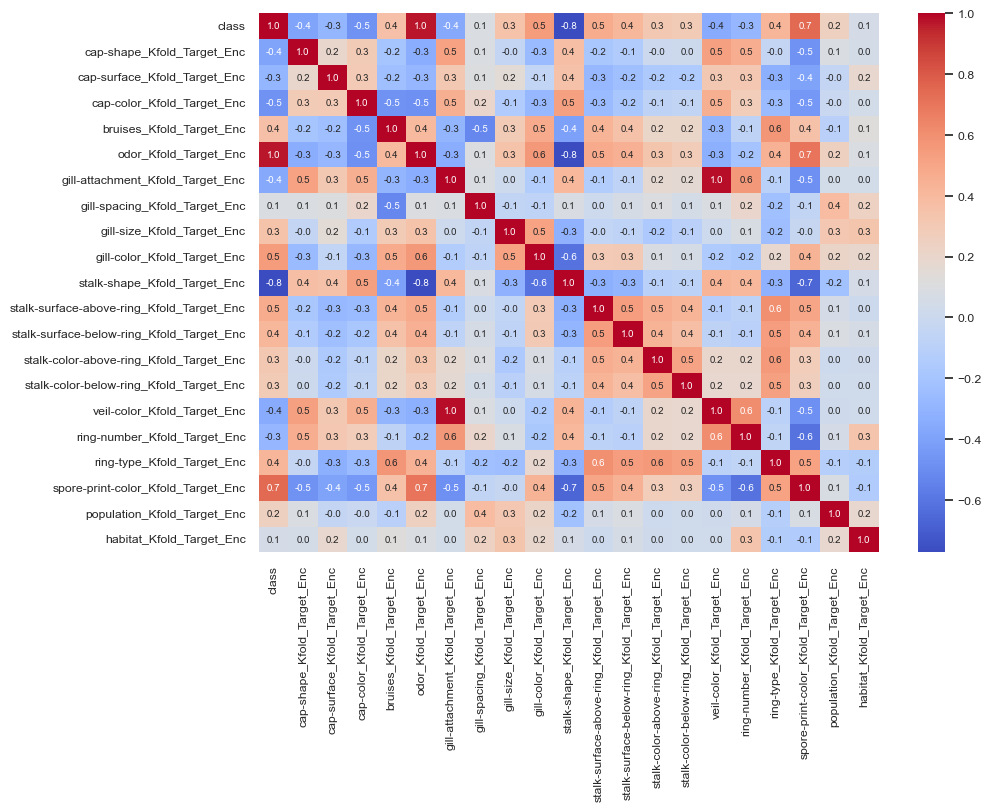

In [19]:
## Plotting a heatmap
plt.figure(figsize=(10,7))
corr_mat = enc_df.corr(numeric_only = True)
sns.heatmap(corr_mat, annot=True, annot_kws={'size': 7}, fmt='.1f', cmap=sns.color_palette("coolwarm", as_cmap=True))
sns.set(font_scale=0.8)

## Logistic Regression Model

In [ ]:
# Splitting the data into dependant and independant variables
X = enc_df.iloc[:, 1:21]
y = enc_df.iloc[:, 0]

In [ ]:
## Splitting the data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [ ]:
## Creating and fitting the model
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [ ]:
## Making predictions
LR_pred = model_LR.predict(X_test)

In [ ]:
## Putting predictions in a dataframe
LR_output = pd.DataFrame({'Actual': y_test, 'Predicted' : LR_pred})
LR_output.head()

,Actual,Predicted
6506,1,1
5656,1,1
4908,1,1
1384,0,0
3305,0,0


In [ ]:
## Evaluate model accuracy
print(classification_report(y_test, LR_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1255
           1       1.00      0.99      1.00      1183

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [ ]:
## Get precise accuracy score
accuracy_LR = accuracy_score(y_test, LR_pred)
print(accuracy_LR)

0.9963084495488105


In [ ]:
## Confusion matrix
LR_conf_mat = confusion_matrix(y_test, LR_pred)
print(LR_conf_mat)

[[1255    0]
 [   9 1174]]


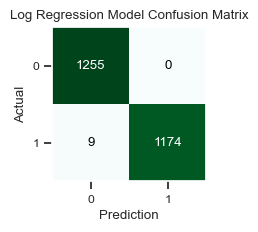

In [ ]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(LR_conf_mat, figsize=(2,2), cmap=plt.cm.BuGn)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Log Regression Model Confusion Matrix')
plt.show()

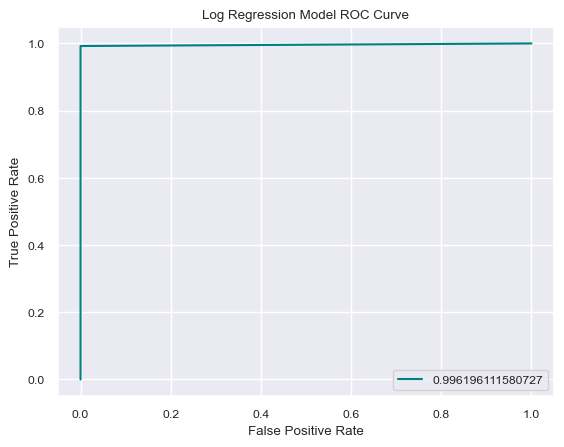

In [ ]:
## Plotting the ROC curve
auc_LR = roc_auc_score(y_test, LR_pred)
fpr, tpr, _ = roc_curve(y_test, LR_pred)
plt.plot(fpr, tpr, color = 'teal', label = auc_LR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Regression Model ROC Curve')
plt.legend()
plt.show()

## Naive Bayes Model

In [ ]:
## Creating and fitting the model
model_NB = GaussianNB()
model_NB.fit(X_train, y_train)

GaussianNB()

In [ ]:
## Making predictions
NB_pred = model_NB.predict(X_test)

In [ ]:
## Putting predictions in a dataframe
NB_output = pd.DataFrame({'Actual': y_test, 'Predicted' : NB_pred})
NB_output.head()

,Actual,Predicted
6506,1,1
5656,1,1
4908,1,1
1384,0,0
3305,0,0


In [ ]:
## Evaluate model accuracy
print(classification_report(y_test, NB_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1255
           1       1.00      0.97      0.99      1183

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438



In [ ]:
## Get precise accuracy score
accuracy_NB = accuracy_score(y_test, NB_pred)
print(accuracy_NB)

0.9864643150123051


In [ ]:
## Confusion matrix
NB_conf_mat = confusion_matrix(y_test, NB_pred)
print(NB_conf_mat)

[[1255    0]
 [  33 1150]]


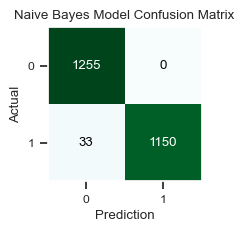

In [ ]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(NB_conf_mat, figsize=(2,2), cmap=plt.cm.BuGn)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Naive Bayes Model Confusion Matrix')
plt.show()

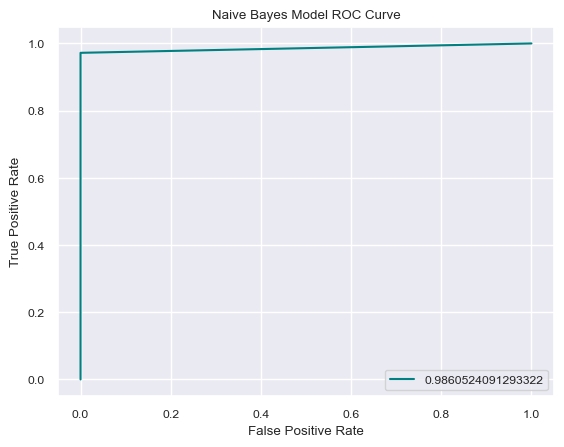

In [ ]:
## Plotting the ROC curve
auc_NB = roc_auc_score(y_test, NB_pred)
fpr, tpr, _ = roc_curve(y_test, NB_pred)
plt.plot(fpr, tpr, color = 'teal', label = auc_NB)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Model ROC Curve')
plt.legend()
plt.show()

## Random Forest

In [ ]:
## Create a random forest classifier
rf = RandomForestClassifier()

## Use grid search to find the best hyperparameters
param_grid = { 
    'n_estimators': [25, 50, 100, 150, 200], 
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
} 

grid_search = GridSearchCV(rf, param_grid = param_grid)

grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=6, n_estimators=25)


In [ ]:
## Create and fit the model
RF_model = RandomForestClassifier(max_depth=6, n_estimators=25)
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=25)

In [ ]:
## Make predictions
RF_pred = RF_model.predict(X_test)

## Put the predictions in a dataframe
RF_output = pd.DataFrame({'Actual': y_test, 'Predicted': RF_pred})
RF_output.head()

,Actual,Predicted
6506,1,1
5656,1,1
4908,1,1
1384,0,0
3305,0,0


In [ ]:
## Evaluate model accuracy
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      1.00      1.00      1183

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [ ]:
## Get precise accuracy score
accuracy_RF = accuracy_score(y_test, RF_pred)
print(accuracy_RF)

1.0


In [ ]:
## Confusion matrix
RF_conf_mat = confusion_matrix(y_test, RF_pred)
print(RF_conf_mat)

[[1255    0]
 [   0 1183]]


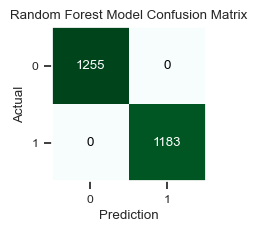

In [ ]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(RF_conf_mat, figsize=(2,2), cmap=plt.cm.BuGn)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Random Forest Model Confusion Matrix')
plt.show()

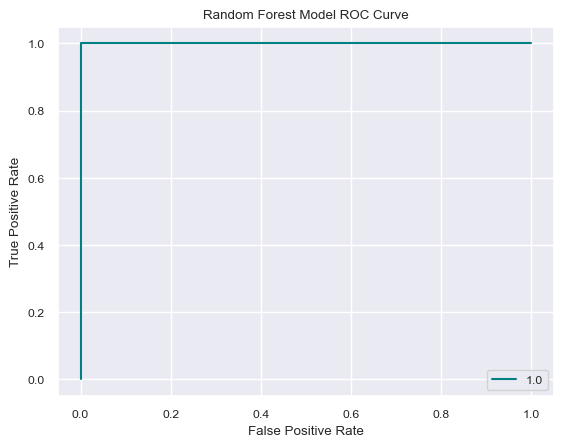

In [ ]:
## Plotting the ROC curve
auc_RF = roc_auc_score(y_test, RF_pred)
fpr, tpr, _ = roc_curve(y_test, RF_pred)
plt.plot(fpr, tpr, color = 'teal', label = auc_RF)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Model ROC Curve')
plt.legend()
plt.show()

## XGBoost

In [ ]:
# Create and fit model
bst = XGBClassifier(n_estimators=2, max_depth=2, gamma=2, eta=0.8,
                    learning_rate=1, objective='binary:logistic')
bst.fit(X_train, y_train)

# Make predictions
XG_pred = bst.predict(X_test)

## Put the predictions in a dataframe
XG_output = pd.DataFrame({'Actual': y_test, 'Predicted': XG_pred})
XG_output.head()

,Actual,Predicted
6506,1,1
5656,1,1
4908,1,1
1384,0,0
3305,0,0


In [ ]:
## Evaluate model accuracy
print(classification_report(y_test, XG_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1255
           1       1.00      0.99      1.00      1183

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [ ]:
## Get precise accuracy score
accuracy_XG = accuracy_score(y_test, XG_pred)
print(accuracy_XG)

0.9975389663658737


In [ ]:
## Confusion matrix
XG_conf_mat = confusion_matrix(y_test, XG_pred)
print(XG_conf_mat)

[[1255    0]
 [   6 1177]]


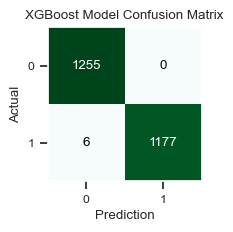

In [ ]:
## Confusion matrix plot
fig, ax = plot_confusion_matrix(XG_conf_mat, figsize=(2,2), cmap=plt.cm.BuGn)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('XGBoost Model Confusion Matrix')
plt.show()

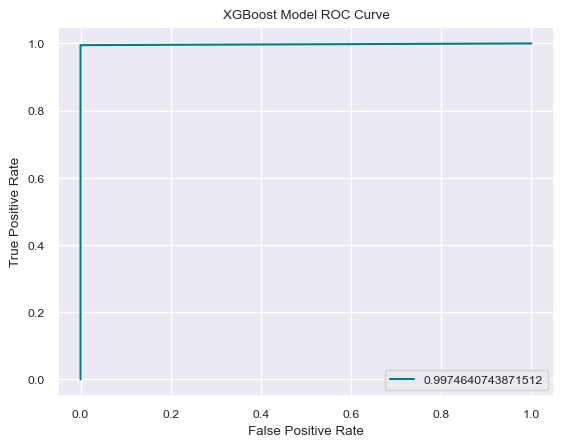

In [ ]:
## Plotting the ROC curve
auc_XG = roc_auc_score(y_test, XG_pred)
fpr, tpr, _ = roc_curve(y_test, XG_pred)
plt.plot(fpr, tpr, color = 'teal', label = auc_XG)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Model ROC Curve')
plt.legend()
plt.show()

### Conclusion

According to the models, it's possible to determine whether mushrooms are poisonous based on their characteristics. The Random Forest model produced the highest accuracy with a perfect score.

However we must be cautious of each models' performance. We know that several features have an imbalanced distribution on the target data and the models may have overfitted. Testing on a different set of data would help to assess the issues.

Possible methods to solve the issues: train with more data, data augmentation, feature selection, cross-validation.

And of course, forage responsibly!